## Introduction

The labels of each face image is embedded in the file name
, formated like [age]_[gender]_[race]_[date&time].jpg

 - **[age]** is an integer from **0 to 116**, indicating the age
 - **[gender]** is either **0 (male) or 1 (female)**
 - **[race]** is an integer from **0 to 4**, denoting _White, Black, Asian, Indian, and Others_ (like Hispanic, Latino, Middle Eastern).
 - **[date&time]** is in the format of **yyyymmddHHMMSSFFF**, showing the date and time an image was collected to UTKFace


Images Shape:
 - **200 x 200 x 3**

## IMPORTS

In [1]:
import os
import cv2

import numpy as np
from numpy.random import seed
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import regex as re

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.random import set_seed

## Analysis Functions

In [2]:
def load_images_from_folder(folder_path,height=200, width=200):
    filenames = [f for f in os.listdir(folder_path) if not f.startswith('.')]
    filenames.sort(key=lambda f: int(re.sub('\D', '', f)))
    images = []
    
    for filename in filenames:
        img_cv = cv2.imread(os.path.join(folder_path,filename))
        if img_cv is not None:
            img = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (height, width))
            images.append(img)
    return images

In [3]:
def load_image_data_into_dataframe(folderpath):
    filenames = [f for f in os.listdir(folder_path)]
    filenames.sort(key=lambda f: int(re.sub('\D', '', f)))
    df = pd.DataFrame()
    
    for filename in filenames:
        parsed_name = filename.split('_')
        df = df.append({'age' : int(parsed_name[0])
                       #,'gender' : parsed_name[1],
                       #'race' : parsed_name[2]
                        }, ignore_index=True)
        
    #df['gender'] = df['gender'].map({'0': 'male', '1': 'female'})
    #df['race'] = df['race'].map({'0': 'White', '1': 'Black', '2': 'Asian', '3': 'Indian', '4': 'Others'})
    
    return df

In [4]:
def show_images(img_list,img_df):
    n=int(len(img_list)/5) +1 
    f = plt.figure(figsize=(25,n*5))
    
    for i,img in enumerate(img_list):
        f.add_subplot(n, 5, i + 1)
        plt.title(f'Age: {img_df.iloc[i]["age"]}',fontweight="bold",fontsize=15)
        
                  #; Race: {img_df.iloc[i]["race"]} Index: {i}',
                  #fontweight="bold",fontsize=15)
        plt.imshow(img)

## Dataset Loading

In [61]:
folder_path = "../data/UTKFace/"

In [62]:
# Loading the Images 
X=load_images_from_folder(folder_path,height=100, width=100)
print("Images Loaded")

Images Loaded


In [9]:
features = load_image_data_into_dataframe(folder_path)
print("Dataframe Loaded")

Dataframe Loaded


In [10]:
print(len(images))
print(len(features))

22006
22006


## Visualization

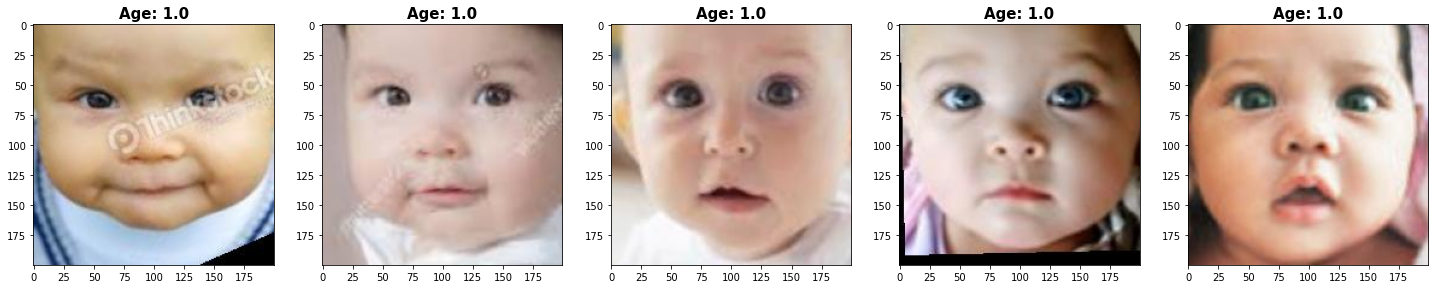

In [15]:
show_images(X[0:5],features.iloc[0:5])

## Distribution

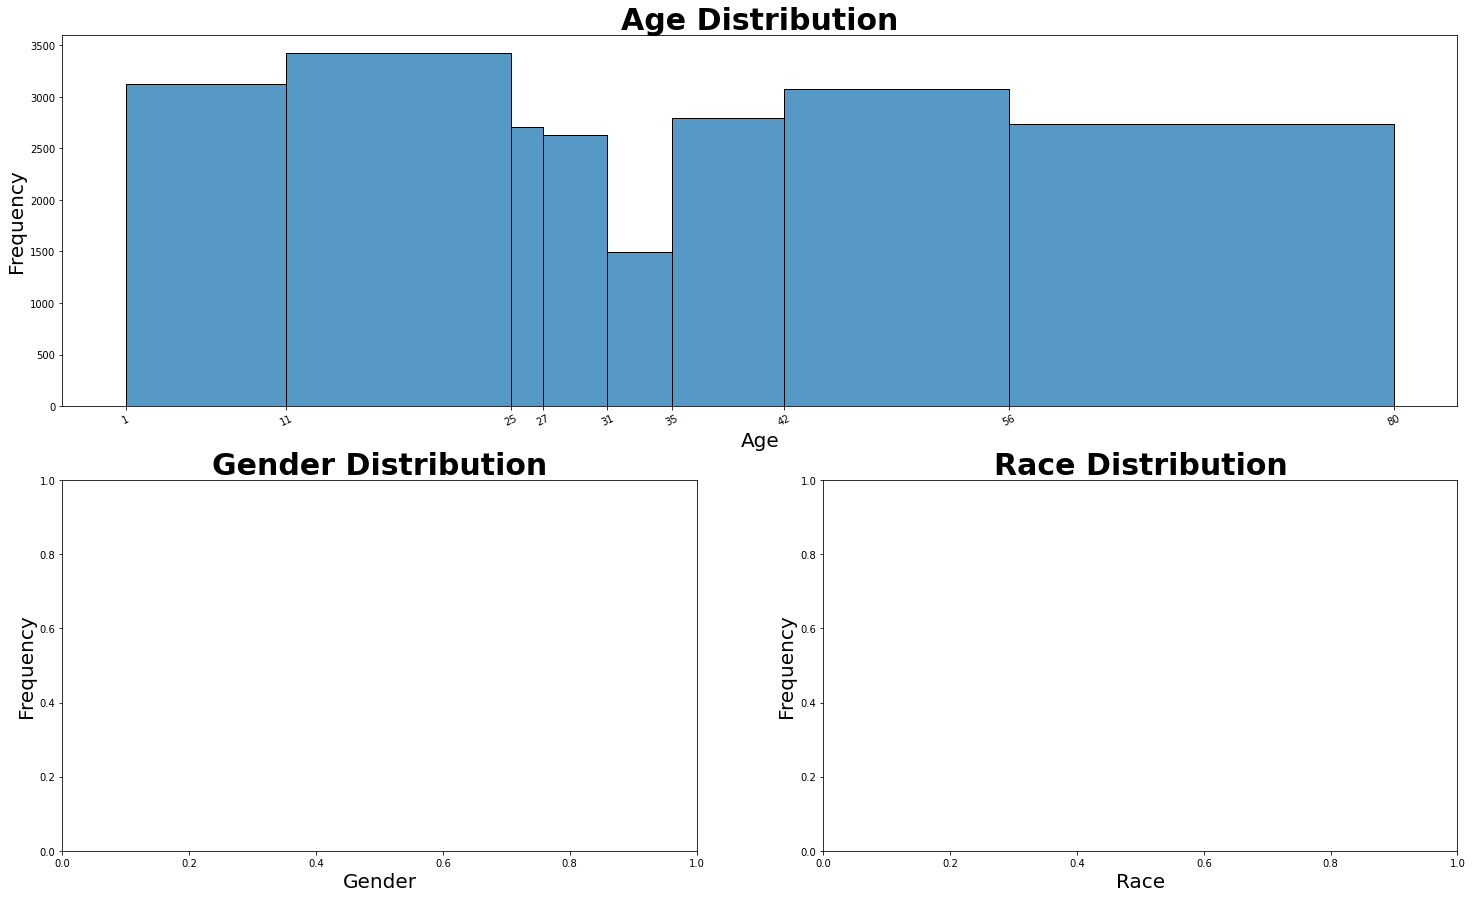

In [53]:
f = plt.figure(figsize=(25,15))

bins_value=[1,11,25,27,31,35,42,56,80]

#bins_value=[1,5,19,25,27,30,34,39,49,59,80]
#bins_value=[1,2,5,11,19,24,26,27,29,31,34,36,39,44,50,55,61,70,80]
#bins_value = list(range(0,85,5))

# Age Histogram
f.add_subplot(211)
sns.histplot(data=features,x = 'age', bins=bins_value)
plt.title('Age Distribution',fontweight="bold",fontsize=30)
plt.xlabel('Age',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.xticks(bins_value, rotation = 25)

# Gender Histogram
f.add_subplot(223)
#sns.histplot(features['gender'])
plt.title('Gender Distribution',fontweight="bold",fontsize=30)
plt.xlabel('Gender',fontsize=20)
plt.ylabel('Frequency',fontsize=20)

# Race Histogram
f.add_subplot(224)
#sns.histplot(features['race'])
plt.title('Race Distribution',fontweight="bold",fontsize=30)
plt.xlabel('Race',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.xticks()

plt.show()

## Image Preprocessing

In [22]:
from PIL import Image
from autocrop import Cropper

In [68]:
img = Image.open('_felix.png')
a = np.asarray(img)
a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)

cropper = Cropper(width=200,height=200)
cropped_array = cropper.crop(a)

In [69]:
cropped_image = Image.fromarray(cropped_array)
cropped_image.save('cropped.png')

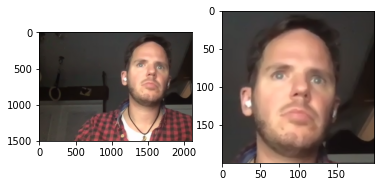

In [70]:
fig, (ax1,ax2) = plt.subplots(1,2)

ax1.imshow(im)
ax2.imshow(cropped_image)

1. Flatten the images **(200,200,3)**
2. Add the target
3. After action 1, a split is performed on each age (randomly). **90/10** per age.
4. The target for the **1st Model is Age.**
5. Age is to be binned on **5y intervals** ([1,5],[6,10],[11,15],...,...,[76,80])
6. To check: Verify if **(Age, Sex and Race)** can also be used as inputs

### 1. Flatenning

In [10]:
print(len(X))
print(type(X))
img_array = np.array(X)

22006
<class 'list'>


In [11]:
images_input = img_array.flatten().reshape(22006, 120000)

In [205]:
#print(np.hstack((images_input[i],np.array(features['age'])[i])).shape)
#np.hstack((images_input[i],np.array(features['age'])[i]))

In [ ]:
#x = np.empty([22006, 120000],dtype = "int32")
#for i in range(0,2):
#    x[i] = np.append(test[i] ,np.array([features['age'][i]]))
    #print(test[-1])

### 2. Binning the Target

In [54]:
features['age_group'] = pd.qcut(features['age'],8).astype(str)
features['age_group'] = features['age_group'].map({
    '(0.999, 8.0]' : 0,
    '(8.0, 23.0]' : 1,
    '(23.0, 26.0]': 2,
    '(26.0, 29.0]': 3,
    '(29.0, 35.0]':4,
    '(35.0, 43.0]':5,
    '(43.0, 55.0]':6,
    '(55.0, 80.0]':7})

In [56]:
images[0].shape

(200, 200, 3)

### 3. Splitting

In [32]:
clear img_array

In [64]:
from sklearn.model_selection import train_test_split

y = features['age_group']
del features
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Data Augmentation

In [ ]:
X = np.array(X)
y = np.array(y)

In [74]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=(0.8, 1.2),
    ) 

datagen.fit(X)

In [99]:
X_augmented_iterator = datagen.flow(X,seed=1, shuffle=False, batch_size=1)

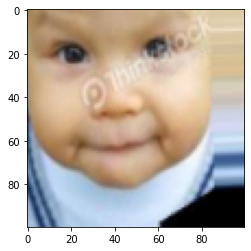

In [88]:
plt.imshow(X_augmented_iterator[0][0].astype("uint8"))

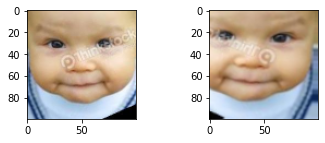

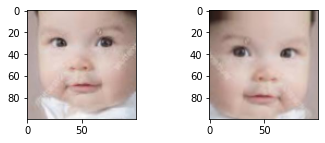

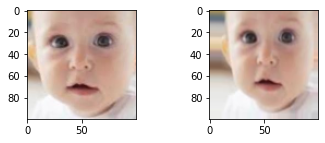

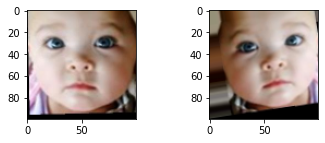

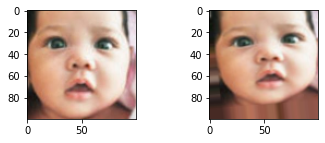

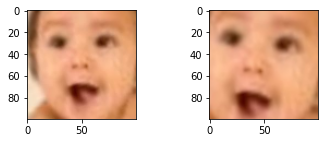

In [101]:
import numpy as np

for i, (raw_image, augmented_image) in enumerate(zip(X, X_augmented_iterator)):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2))
    ax1.imshow(raw_image)
    ax2.imshow(augmented_image[0].astype("uint8"))
    plt.show()
    
    if i > 4:
        break

## PCA

In [91]:
from sklearn.decomposition import IncrementalPCA,PCA

In [92]:
images_input.shape

(22006, 120000)

In [93]:
pca = PCA(n_components=50,random_state=42)
#pca = SparsePCA(n_components=150,random_state=42)
#pca = IncrementalPCA(n_components=150,batch_size=1000,copy=False)
#svd = TruncatedSVD(n_components=100,random_state=42)

In [94]:
data_projected = pca.fit(images_input[:2000])

#_transform(images_input[:200])
#data_projected.shape

In [95]:
data_projected

PCA(copy=True, iterated_power='auto', n_components=50, random_state=42,
    svd_solver='auto', tol=0.0, whiten=False)

In [96]:
data_reconstruced = pca.inverse_transform(data_projected)
data_reconstruced.shape

TypeError: unsupported operand type(s) for *: 'PCA' and 'float'

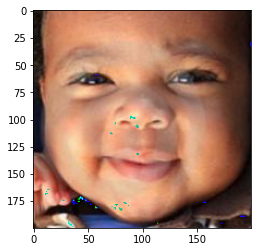

In [47]:
plt.imshow((data_reconstruced[150].reshape((200,200,3))).astype(np.uint8))

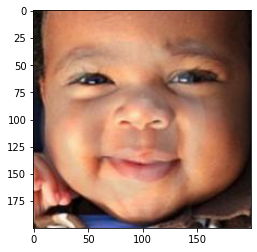

In [48]:
plt.imshow(images[150])

Text(0.5, 1.0, 'Mean Face of the Input')

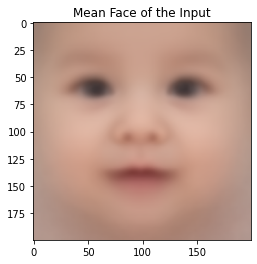

In [49]:
plt.imshow(np.mean(images_input[:1000],axis=0).reshape((200,200,3)).astype(np.uint8))
plt.title("Mean Face of the Input")

Text(0.5, 1.0, 'Mean Face of the PCA')

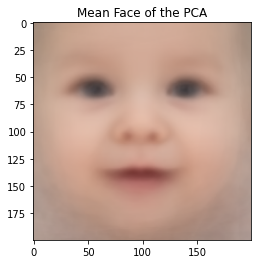

In [50]:
plt.imshow(pca.mean_.reshape((200,200,3)).astype(np.uint8))
plt.title("Mean Face of the PCA")

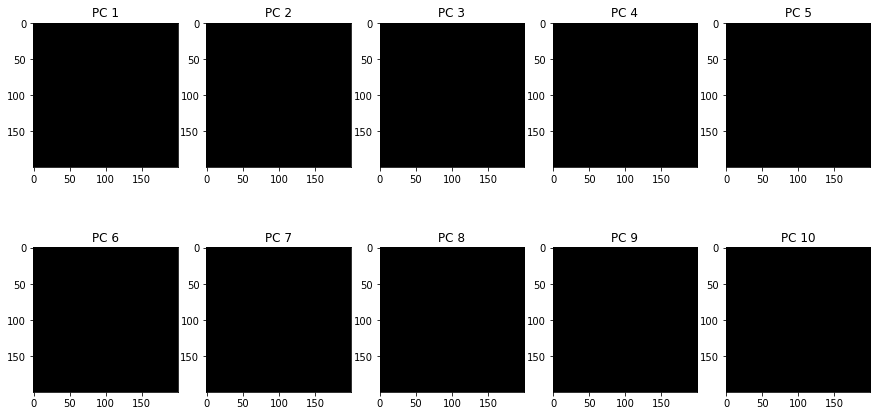

In [51]:
fig = plt.figure(figsize=(15,20))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.title(f'PC {i+1}', size=12)
    plt.imshow(pca.components_[i].reshape(200,200,3).astype(np.uint8))

In [47]:
len(pca.components_[0])

120000

# 1-Off Accuracy

## Loading Inputs

In [2]:
inputs_path = "../data/cnn_inputs/"

In [3]:
X_test = np.load(inputs_path+"X_test.npy")
y_test_cat = np.load(inputs_path+"y_test_cat.npy")
y_pred = np.load(inputs_path+"y_pred.npy")

In [4]:
print(len(y_pred),"....",type(y_pred))
print(len(y_test_cat),"....",type(y_test_cat))

5502 .... <class 'numpy.ndarray'>
5502 .... <class 'numpy.ndarray'>


In [66]:
def one_off_accuracy(y_test_cat,y_pred):
    
    i_ind = []
    accurate = 0
    
    hit_miss = pd.DataFrame(data = 0, dtype="int16"
                          ,index = np.linspace(0,y_test_cat.shape[1]-1,y_test_cat.shape[1],dtype="int8")
                          ,columns = ['Hit','Miss'])
    
    conf = pd.DataFrame(data = 0, dtype="int16"
                          ,index = np.linspace(0,y_test_cat.shape[1]-1,y_test_cat.shape[1],dtype="int8")
                          ,columns = np.linspace(0,y_test_cat.shape[1]-1,y_test_cat.shape[1],dtype="int8"))
    
    for i in range(len(y_test_cat)):
        
        # 1-Off Accuracy
        i_ind = [y_pred[i].argmax()-1,y_pred[i].argmax(),y_pred[i].argmax()+1]
        if y_test_cat[i].argmax() in i_ind:
            accurate += 1
    
        # Hit/Miss Matrix
            hit_miss.at[y_test_cat[i].argmax(),"Hit"] += 1
        else:
            hit_miss.at[y_test_cat[i].argmax(),"Miss"] += 1
            
        # Confusion Matrix
        conf.at[y_test_cat[i].argmax(),y_pred[i].argmax()] += 1
    
    conf["Total"] = np.sum(y_test_cat,axis=0,dtype="int16")
    for k in range(0,y_test_cat.shape[1]):
        if (conf.iloc[k,k] !=0) and (conf.at[k,"Total"]!=0):
            conf.at[k,"Hit Rate"] = round(100*np.divide(conf.at[k,k],conf.at[k,"Total"]),1)
            
    print(f"The 1-Off Accuracy is {round(100*accurate/len(y_test_cat),2)}%")
    return hit_miss,conf

In [67]:
matrix,conf = one_off_accuracy(y_test_cat,y_pred)

The 1-Off Accuracy is 59.49%


In [68]:
conf

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,Total,Hit Rate
0,902,18,6,6,0,0,274,0,0,0,...,7,16,19,0,0,0,0,0,1248,72.3
1,222,50,43,26,0,0,57,0,0,0,...,6,15,19,0,0,0,0,0,438,11.4
2,17,9,46,19,0,1,26,0,0,0,...,0,1,2,0,0,0,0,0,121,38.0
3,29,6,35,42,0,3,50,0,0,0,...,1,0,2,0,0,0,0,0,168,25.0
4,27,0,2,24,1,5,128,0,0,0,...,0,0,0,0,0,0,0,0,187,0.5
5,55,0,0,7,0,15,408,0,0,0,...,0,0,1,0,0,0,0,0,486,3.1
6,239,0,1,7,0,18,773,0,0,0,...,0,3,3,0,0,0,0,0,1044,74.0
7,230,0,1,0,0,0,306,0,0,0,...,3,3,2,0,0,0,0,0,545,NaN
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN


In [33]:
for i in range(0,5):
    print(y_test_cat[i].argmax() ,"--------",y_pred[i].argmax())

6 -------- 0
0 -------- 6
6 -------- 6
1 -------- 0
3 -------- 3
